# Imports

In [51]:
import numpy as np
import torch
from scipy import stats
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import time
import inspect
import collections
from IPython import display

# The Optimization Problem

## The Objective Function

In [52]:
class Trainer:
    """The base class for training models with data.
    
    PyTorch equivalent of d2l.Trainer class.
    """
    
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
        self.gpus = [torch.device(f'cuda:{i}') for i in range(min(num_gpus, torch.cuda.device_count()))]
    
    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes."""
        import inspect
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k: v for k, v in local_vars.items()
                       if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)
    
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
    
    def prepare_model(self, model):
        model.trainer = self
        # Remove board reference as it's d2l-specific
        # model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model
    
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        """Train and validate for one epoch."""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            loss.backward()
            if self.gradient_clip_val > 0:
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
            self.train_batch_idx += 1
        
        if self.val_dataloader is None:
            return
        
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
    
    def prepare_batch(self, batch):
        """Prepare batch for training/validation."""
        if self.gpus:
            batch = [a.to(self.gpus[0]) if isinstance(a, torch.Tensor) else a for a in batch]
        return batch
    
    def clip_gradients(self, grad_clip_val, model):
        """Clip gradients to prevent exploding gradients."""
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm


In [53]:
class HPOTrainer(Trainer):
    def validation_error(self):
        self.model.eval()
        accuracy = 0
        num_batches = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)
            num_batches += 1
        return 1 - accuracy / num_batches if num_batches > 0 else torch.tensor(1.0)

In [54]:
class FashionMNIST:
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        import os
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        # Use a writable data directory instead of root
        self.root = os.path.join(os.path.expanduser("~"), ".data", "FashionMNIST")
        os.makedirs(self.root, exist_ok=True)
        self.batch_size = batch_size
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train)
    
    def train_dataloader(self):
        """Return training dataloader."""
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        """Return validation dataloader."""
        return self.get_dataloader(train=False)
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        plt.figure(figsize=(2 * ncols, 2 * nrows))
        max_imgs = min(X.shape[0], nrows * ncols)
        for i in range(max_imgs):
            plt.subplot(nrows, ncols, i + 1)
            img = X[i].squeeze().numpy()
            plt.imshow(img, cmap='gray')
            plt.title(labels[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

class SoftmaxRegression(nn.Module):
    def __init__(self, num_inputs=784, num_outputs=10, lr=0.01, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.lr = lr
        self.sigma = sigma
        self.W = nn.Parameter(torch.normal(0, sigma, size=(num_inputs, num_outputs)))
        self.b = nn.Parameter(torch.zeros(num_outputs))

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return nn.functional.softmax(torch.matmul(X, self.W) + self.b, dim=1)
    
    def loss(self, y_hat, y):
        # Convert y to one-hot encoding for cross entropy
        y_one_hot = nn.functional.one_hot(y, self.num_outputs).float()
        return -torch.sum(y_one_hot * torch.log(y_hat + 1e-8)) / y.shape[0]
    
    def training_step(self, batch):
        x, y = batch
        y_hat = self(x)
        return self.loss(y_hat, y)
    
    def validation_step(self, batch):
        x, y = batch
        y_hat = self(x)
        return self.loss(y_hat, y)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)
    
    def accuracy(self, y_hat, y):
        predictions = torch.argmax(y_hat, dim=1)
        return (predictions == y).float().mean()

In [55]:
def hpo_objective_softmax_classification(config, max_epochs=8):
    learning_rate = config["learning_rate"]
    trainer = HPOTrainer(max_epochs=max_epochs)
    data = FashionMNIST(batch_size=16)
    model = SoftmaxRegression(num_outputs=10, lr=learning_rate)
    trainer.fit(model=model, data=data)
    return trainer.validation_error().detach().numpy()

## The Configuration Space

In [56]:
config_space = {"learning_rate": stats.loguniform(1e-4, 1)}

# Random Search

In [57]:
errors, values = [], []
num_iterations = 5

for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f"    validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)

Trial 0: learning_rate = 0.4634164920089844
    validation_error = 0.17650002241134644
Trial 1: learning_rate = 0.03754494658719756
    validation_error = 0.16289997100830078
Trial 2: learning_rate = 0.0005104727551922282
    validation_error = 0.21689999103546143
Trial 3: learning_rate = 0.025222770380536125
    validation_error = 0.16519999504089355
Trial 4: learning_rate = 0.5749629320405331
    validation_error = 0.19300001859664917


In [58]:
best_idx = np.argmin(errors)
print(f"optimal learning rate = {values[best_idx]}")

optimal learning rate = 0.03754494658719756


# Hyperparameter Optimization Class

## Searcher

In [59]:
class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [60]:
class HPOSearcher(HyperParameters):
    def sample_configuration(self):
        raise NotImplemented
    
    def update(self, config: dict, error: float, additional_info=None):
        pass
    

In [61]:
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space: dict, initial_config=None):
        self.save_hyperparameters()

    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result
    

## Scheduler

In [62]:
class HPOScheduler(HyperParameters):
    def suggest(self) -> dict:
        raise NotImplemented
    
    def update(self, config: dict, error: float, info=None):
        raise NotImplemented

In [63]:
class BasicScheduler(HPOScheduler):
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()

    def suggest(self) -> dict:
        return self.searcher.sample_configuration()

    def update(self, config: dict, error: float, info=None):
        self.searcher.update(config, error, info)

## Tuner

In [64]:
class HPOTuner(HyperParameters):
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []
    
    def bookkeeping(self, config: dict, error: float, runtime: float):
        self.records.append({"config": config, "error": error, "runtime": runtime})
        # Check if the last hyperparameter configuration performs better
        # than the incumbent
        if self.incumbent is None or self.incumbent_error > error:
            self.incumbent = config
            self.incumbent_error = error
        # Add current best observed performance to the optimization trajectory
        self.incumbent_trajectory.append(self.incumbent_error)
        # Update runtime
        self.current_runtime += runtime
        self.cumulative_runtime.append(self.current_runtime)
        
    def run(self, number_of_trials: int):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f"Trial {i}: {config}")
            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())
            self.scheduler.update(config, error)
            end_time = time.time()
            runtime = end_time - start_time
            self.bookkeeping(config, error, runtime)
            print(f"       error: {error}, runtime: {runtime}")
    
            
        

## Example: Hyperparameter Optimization of a Convolutional Neural Network

In [91]:
def init_cnn(module): 
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(nn.Module):  
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.lr = lr
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
    
    def forward(self, X):
        return self.net(X)
    
    def training_step(self, batch):
        x, y = batch
        y_hat = self(x)
        criterion = nn.CrossEntropyLoss()
        return criterion(y_hat, y)
    
    def validation_step(self, batch):
        x, y = batch
        y_hat = self(x)
        criterion = nn.CrossEntropyLoss()
        return criterion(y_hat, y)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)
    
    def accuracy(self, y_hat, y):
        predictions = torch.argmax(y_hat, dim=1)
        return (predictions == y).float().mean()
    
    def train_manual(self, train_loader, num_epochs=10, lr=0.1):
        """Alternative training method (not used with Trainer)."""
        self.apply(init_cnn)
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(num_epochs):
            for batch in train_loader:
                X, y = batch
                X, y = X, y
                optimizer.zero_grad()
                output = self(X)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
            print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

In [92]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    model = LeNet(lr=learning_rate, num_classes=10)
    trainer = HPOTrainer(max_epochs=max_epochs)
    data = FashionMNIST(batch_size=batch_size)
    # Initialize lazy layers by passing a sample input through the network
    sample_input = next(iter(data.get_dataloader(True)))[0]
    _ = model(sample_input)
    # Apply weight initialization
    model.apply(init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [93]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

In [94]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

Trial 0: {'learning_rate': 0.1, 'batch_size': 128}
       error: 0.27264636754989624, runtime: 77.81024312973022
Trial 1: {'learning_rate': 0.2736394111846883, 'batch_size': 137}
       error: 0.22300130128860474, runtime: 76.18473196029663
Trial 2: {'learning_rate': 0.01412903611104856, 'batch_size': 201}
       error: 0.9000033140182495, runtime: 101.92927598953247
Trial 3: {'learning_rate': 0.4453180636741058, 'batch_size': 108}
       error: 0.16423970460891724, runtime: 88.99084115028381
Trial 4: {'learning_rate': 0.36156509626521943, 'batch_size': 183}
       error: 0.20643532276153564, runtime: 71.87431502342224


In [95]:
class ProgressBoard(HyperParameters):
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)


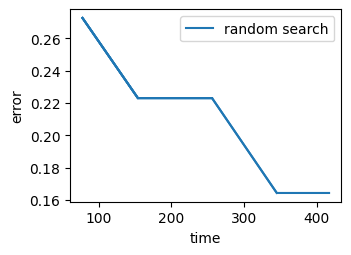

In [96]:
board = ProgressBoard(xlabel="time", ylabel="error")
for time_stamp, error in zip(
    tuner.cumulative_runtime, tuner.incumbent_trajectory
):
    board.draw(time_stamp, error, "random search", every_n=1)

# Asynchronous Random Search

In [97]:
import logging
logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch
from syne_tune import Reporter

### Objective Function

In [98]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    # Import necessary modules
    import torch
    from torch import nn
    from torchvision import transforms
    import torchvision
    import os
    import inspect
    from syne_tune import Reporter
    
    # Define Trainer class
    class Trainer:
        """The base class for training models with data."""
        def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
            self.save_hyperparameters()
            if num_gpus > 0 and not torch.cuda.is_available():
                num_gpus = 0
            self.gpus = [torch.device(f'cuda:{i}') for i in range(min(num_gpus, torch.cuda.device_count()))]
        
        def save_hyperparameters(self, ignore=[]):
            """Save function arguments into class attributes."""
            frame = inspect.currentframe().f_back
            _, _, _, local_vars = inspect.getargvalues(frame)
            self.hparams = {k: v for k, v in local_vars.items()
                           if k not in set(ignore+['self']) and not k.startswith('_')}
            for k, v in self.hparams.items():
                setattr(self, k, v)
        
        def prepare_data(self, data):
            self.train_dataloader = data.train_dataloader()
            self.val_dataloader = data.val_dataloader()
            self.num_train_batches = len(self.train_dataloader)
            self.num_val_batches = (len(self.val_dataloader)
                                    if self.val_dataloader is not None else 0)
        
        def prepare_model(self, model):
            model.trainer = self
            if self.gpus:
                model.to(self.gpus[0])
            self.model = model
        
        def fit(self, model, data):
            self.prepare_data(data)
            self.prepare_model(model)
            self.optim = model.configure_optimizers()
            self.epoch = 0
            self.train_batch_idx = 0
            self.val_batch_idx = 0
            for self.epoch in range(self.max_epochs):
                self.fit_epoch()
        
        def fit_epoch(self):
            """Train and validate for one epoch."""
            self.model.train()
            for batch in self.train_dataloader:
                loss = self.model.training_step(self.prepare_batch(batch))
                self.optim.zero_grad()
                loss.backward()
                if self.gradient_clip_val > 0:
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
                self.train_batch_idx += 1
            
            if self.val_dataloader is None:
                return
            
            self.model.eval()
            for batch in self.val_dataloader:
                with torch.no_grad():
                    self.model.validation_step(self.prepare_batch(batch))
                self.val_batch_idx += 1
        
        def prepare_batch(self, batch):
            """Prepare batch for training/validation."""
            if self.gpus:
                batch = [a.to(self.gpus[0]) if isinstance(a, torch.Tensor) else a for a in batch]
            return batch
        
        def clip_gradients(self, grad_clip_val, model):
            """Clip gradients to prevent exploding gradients."""
            params = [p for p in model.parameters() if p.requires_grad]
            norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
            if norm > grad_clip_val:
                for param in params:
                    param.grad[:] *= grad_clip_val / norm
    
    # Define HPOTrainer class
    class HPOTrainer(Trainer):
        def validation_error(self):
            self.model.eval()
            accuracy = 0
            num_batches = 0
            for batch in self.val_dataloader:
                with torch.no_grad():
                    x, y = self.prepare_batch(batch)
                    y_hat = self.model(x)
                    accuracy += self.model.accuracy(y_hat, y)
                num_batches += 1
            return 1 - accuracy / num_batches if num_batches > 0 else torch.tensor(1.0)
    
    # Define FashionMNIST class
    class FashionMNIST:
        """The Fashion-MNIST dataset."""
        def __init__(self, batch_size=64, resize=(28, 28)):
            trans = transforms.Compose([transforms.Resize(resize),
                                        transforms.ToTensor()])
            self.root = os.path.join(os.path.expanduser("~"), ".data", "FashionMNIST")
            os.makedirs(self.root, exist_ok=True)
            self.batch_size = batch_size
            self.train = torchvision.datasets.FashionMNIST(
                root=self.root, train=True, transform=trans, download=True)
            self.val = torchvision.datasets.FashionMNIST(
                root=self.root, train=False, transform=trans, download=True)
        
        def get_dataloader(self, train):
            data = self.train if train else self.val
            return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train)
        
        def train_dataloader(self):
            """Return training dataloader."""
            return self.get_dataloader(train=True)
        
        def val_dataloader(self):
            """Return validation dataloader."""
            return self.get_dataloader(train=False)
    
    # Define init_cnn function
    def init_cnn(module): 
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            nn.init.xavier_uniform_(module.weight)
    
    # Define LeNet class
    class LeNet(nn.Module):  
        """The LeNet-5 model."""
        def __init__(self, lr=0.1, num_classes=10):
            super().__init__()
            self.lr = lr
            self.net = nn.Sequential(
                nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Flatten(),
                nn.LazyLinear(120), nn.Sigmoid(),
                nn.LazyLinear(84), nn.Sigmoid(),
                nn.LazyLinear(num_classes))
        
        def forward(self, X):
            return self.net(X)
        
        def training_step(self, batch):
            x, y = batch
            y_hat = self(x)
            criterion = nn.CrossEntropyLoss()
            return criterion(y_hat, y)
        
        def validation_step(self, batch):
            x, y = batch
            y_hat = self(x)
            criterion = nn.CrossEntropyLoss()
            return criterion(y_hat, y)
        
        def configure_optimizers(self):
            return torch.optim.SGD(self.parameters(), lr=self.lr)
        
        def accuracy(self, y_hat, y):
            predictions = torch.argmax(y_hat, dim=1)
            return (predictions == y).float().mean()
    
    # Main function body
    model = LeNet(lr=learning_rate, num_classes=10)
    trainer = HPOTrainer(max_epochs=1, num_gpus=0)  # Set to 0 for CPU-only
    data = FashionMNIST(batch_size=batch_size)
    
    # Initialize lazy layers by passing a sample input through the network
    sample_input = next(iter(data.get_dataloader(True)))[0]
    _ = model(sample_input)
    # Apply weight initialization
    model.apply(init_cnn)
    
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # Initialize the state of Trainer
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()
        validation_error = trainer.validation_error().cpu().detach().numpy()
        report(epoch=epoch, validation_error=float(validation_error))

### Asynchronous Scheduler

In [99]:
#n_workers = 2  # Needs to be <= the number of available GPUs

max_wallclock_time = 12 * 60  # 12 minutes

In [100]:
mode = "min"
metric = "validation_error"

In [101]:
config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": 10,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

In [102]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

In [103]:
scheduler_args = dict(
    metrics=[metric],  # Note: plural and must be a list
    do_minimize=(mode == "min"),  # Convert mode to boolean
    points_to_evaluate=[initial_config]
)
scheduler = RandomSearch(config_space=config_space, **scheduler_args)

In [106]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)

tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=4,  # Set to 1 for CPU-only (sequential execution). For parallel CPU trials, use 2-4 based on CPU cores
    print_update_interval=int(max_wallclock_time * 0.6),
)

In [107]:
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /Users/ishaanpaul/syne-tune/python-entrypoint-2025-11-21-00-19-43-048
INFO:syne_tune.backend.local_backend:running subprocess with command: /Users/ishaanpaul/Desktop/Extras/Deep-Learning/deep-learning-hpo/bin/python /Users/ishaanpaul/Desktop/Extras/Deep-Learning/deep-learning-hpo/lib/python3.12/site-packages/syne_tune/backend/python_backend/python_entrypoint.py --learning_rate 0.01335622610176091 --batch_size 210 --max_epochs 10 --tune_function_root /Users/ishaanpaul/syne-tune/python-entrypoint-2025-11-21-00-19-43-048/tune_function --tune_function_hash cb048f2a36953e16272621bd1cd259ff --st_checkpoint_dir /Users/ishaanpaul/syne-tune/python-entrypoint-2025-11-21-00-19-43-048/1/checkpoints
INFO:syne_tune.tuner:(trial 1) - scheduled config {'learning_rate': 0.01335622610176091, 'batch_size': 210, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: /Users/ishaanpaul/Desktop/Extras/Deep-Learning/deep-

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        1  Completed    10       0.013356         210          10     10          0.899817   137.438543
        2  Completed    10       0.027054         207          10     10          0.862525   137.145964
        3  Completed    10       0.022290         109          10     10          0.899831   138.978790
        4  Completed    10       0.010947          66          10     10          0.899944   143.049948
        5  Completed    10       0.026404          93          10     10          0.476520   118.874169
        6  Completed    10       0.360392         245          10     10          0.232068   116.366621
        7  Completed    10       0.074535         136          10     10          0.305843   117.970291
        8  Completed    10       0.022698         237          10     10          0.898615   116.480699

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ishaanpaul/syne-tune/python-entrypoint-2025-11-21-00-19-43-048/0/end'

/Users/ishaanpaul/Desktop/Extras/Deep-Learning/deep-learning-hpo/lib/python3.12/site-packages/syne_tune/experiments/experiment_result.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 1000x500 with 0 Axes>

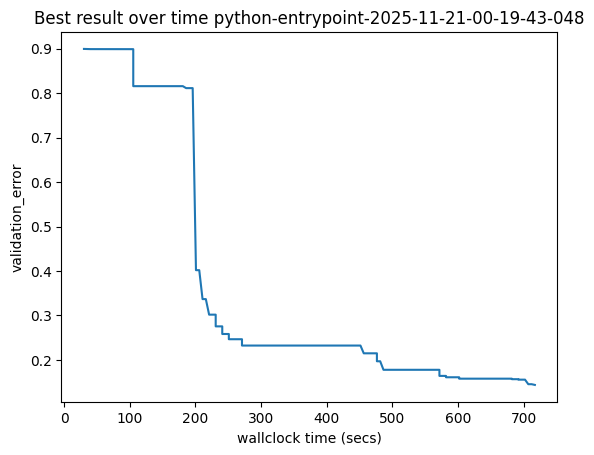

In [108]:
plt.figure(figsize=(10, 5))
tuning_experiment = load_experiment(tuner.name)
tuning_experiment.plot()

## Visualizing the Asynchronous Optimization process

Text(0, 0.5, 'objective function')

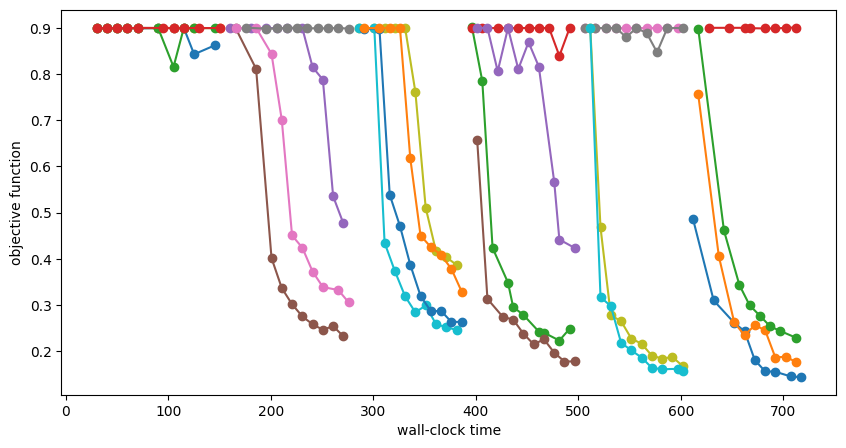

In [109]:
plt.figure(figsize=(10, 5))
results = tuning_experiment.results

for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    plt.plot(
        df["st_tuner_time"],
        df["validation_error"],
        marker="o"
    )

plt.xlabel("wall-clock time")
plt.ylabel("objective function")